## Planetary system simulation

In [162]:
import numpy as np
#constants:
G=6.67430E-11
#using other units i.e. AU should be considered

In [163]:
#class describing planet or asteroids
class SpaceObject:
    
    def __init__(self,name,mass,radius,initialPosition=np.array([.0,.0,.0]),
                 initialVelocityVector=np.array([.0,.0,.0]),color='blue'):
        # Privtization of attributes?
        self.mass = mass
        self.velocity = initialVelocityVector
        self.name = name
        self.position = initialPosition
        self.radius = radius
        self.color = color
        self.positionHistory = np.empty((0,3),float)
        
    def set_initial_conditions_by_au(self, initial_position_au: np.ndarray, initial_velocity_au: np.ndarray) -> None:
        """
        Set initial position and velocity of a planet using Astronomic Units
        """
        AU = 149597870700
        self.position = initial_position_au * AU
        self.velocity = initial_velocity_au * AU/(24*60*60)
        
    def acceleration(self,bodies):
        #https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
        acc = np.array([.0,.0,.0])
        for name,body in bodies:
            if not name==self.name:
                acc += body.mass*(body.position-self.position)/np.linalg.norm(body.position-self.position)**3
        return G*acc
    
    def setNewPosition(self,newPos):
        self.positionHistory = np.append(self.positionHistory,np.array([self.position]),axis=0)
        self.position = newPos

    def __str__(self):
        return "{:E};{:E};{:E};{:E};{:E};{:E};".format(
                            self.position[0], self.position[1], self.position[2],
                            self.velocity[0], self.velocity[1], self.velocity[2])
    

        

* [planet position calculator] (uses AU for reference and treats Sun as the center of coordinate system)  
* Alternate data (_1980's paper - probably outdated_) is placed in *__solar_system.docx__*

[planet position calculator]: <http://cosinekitty.com/solar_system.html>

In [164]:
#collection of all objects in simulation as dictionary (key = name):

celestialBodies = {}
celestialBodies["Sun"] = SpaceObject(name="Sun",mass=1.98847E30,
                                     initialPosition=np.array([.0,.0,.0]),initialVelocityVector=[.0,.0,.0],
                                    radius=6.96340000E8, color="yellow")

celestialBodies["Mercury"] = SpaceObject(name="Mercury", mass=3.285E23, radius=2439.7, color="orange")
celestialBodies["Mercury"].set_initial_conditions_by_au(
    initial_position_au=np.array([-2.503E-01, +1.873E-01, +1.260E-01]), 
    initial_velocity_au=np.array([-2.439E-02, -1.850E-02, -7.353E-03]))
    
celestialBodies["Venus"] = SpaceObject(name="Venus", mass=2.867E24, radius=6051.8, color="olive")
celestialBodies["Venus"].set_initial_conditions_by_au(
    initial_position_au=np.array([+1.748E-02, -6.624E-01, -2.991E-01]),
    initial_velocity_au=np.array([+2.009E-03, +8.365E-04, -8.948E-04]))

celestialBodies["Earth"] = SpaceObject(name="Earth", mass=6.046E24, radius=6371, color="blue")
celestialBodies["Earth"].set_initial_conditions_by_au(
    initial_position_au=np.array([-9.092E-01, +3.593E-01, +1.558E-01]),
    initial_velocity_au=np.array([-7.086E-03, -1.456E-02, -6.311E-03]))

celestialBodies["Mars"] = SpaceObject(name="Mars", mass=6.39E23, radius=3389.5, color="red")
celestialBodies["Mars"].set_initial_conditions_by_au(
    initial_position_au=np.array([+1.203E+00, +7.271E-01, +3.010E-01]),
    initial_velocity_au=np.array([-7.124E-03, +1.166E-02, +5.542E-03]))

celestialBodies["Jupiter"] = SpaceObject(name="Jupiter", mass=1.898E27, radius=69911, color="orange")
celestialBodies["Jupiter"].set_initial_conditions_by_au(
    initial_position_au=np.array([+3.733E+00, +3.052E+00, +1.217E+00]),
    initial_velocity_au=np.array([-5.087E-03, +5.494E-03, +2.479E-03]))

celestialBodies["Saturn"] = SpaceObject(name="Saturn", mass=5.683E26, radius=58232, color="brown")
celestialBodies["Saturn"].set_initial_conditions_by_au(
    initial_position_au=np.array([+6.164E+00, +6.367E+00, +2.365E+00]),
    initial_velocity_au=np.array([-4.427E-03, +3.394E-03, +1.592E-03]))

celestialBodies["Uranus"] = SpaceObject(name="Uranus", mass=8.681E25, radius=25362, color="purple")
celestialBodies["Uranus"].set_initial_conditions_by_au(
    initial_position_au=np.array([+1.458E+01, -1.237E+01, -5.624E+00]),
    initial_velocity_au=np.array([+2.648E-03, +2.488E-03, +1.052E-03]))

celestialBodies["Neptune"] = SpaceObject(name="Neptune", mass=1.024E26, radius=25622, color="cyan")
celestialBodies["Neptune"].set_initial_conditions_by_au(
    initial_position_au=np.array([+1.695E+01, -2.289E+01, -9.790E+00]),
    initial_velocity_au=np.array([+2.569E-03, +1.682E-03, +6.246E-04]))

In [166]:
#function that calculates center of mass for given list of planets / asteroids
def calculateModelCenterOfMass() -> np.ndarray:
    pos = np.array([.0,.0,.0])
    massSum = 0
    for key,body in celestialBodies.items():
        pos += body.position*body.mass
        massSum += body.mass
    return pos/massSum

def printBodies(bodies) -> None:
    for name,body in bodies.items():
        print(body)

def saveSimulationResultsToFile(fileName,celestialBodies) -> None:
    #TODO: add timestamps in separate column
    header = ""
    data = None
    for name,body in celestialBodies.items():
        if data is None:
            data = body.positionHistory
        else:
            data = np.append(data,body.positionHistory,axis=1)
            
        header += "{}_X;{}_Y;{}_Z;".format(name,name,name)
        
    np.savetxt(fileName, data, delimiter=",",header=header)
    print(data.shape)

In [167]:
#single step of simulation
def calculateNewPositions(bodies,dt):
    positions = dict.fromkeys(bodies.keys())
    halfStepVelocities = dict.fromkeys(bodies.keys())
    for name,body in bodies.items():
        #https://en.wikipedia.org/wiki/Leapfrog_integration probably can do better with Runge-Kutta method
        # conditon: dt<2/omega
        # 'kick-drift-form'
        
        halfStepVelocities[name] = body.velocity + body.acceleration(bodies.items())*dt/2
        positions[name] = body.position + halfStepVelocities[name]*dt
     
    #apply new positons after all calculations for this timestep
    for name,body in bodies.items():
        body.setNewPosition(positions[name])
        #calculate velocity considering new position
        body.velocity = halfStepVelocities[name] + body.acceleration(bodies.items())*dt/2
        

In [168]:
import datetime

      
start = datetime.datetime.now()
dt = 1*24*60*60
days = 15*365
end = start + datetime.timedelta(days = days)
simulationSteps = np.array([start + datetime.timedelta(days = day) for day in range(days)])

for day in simulationSteps:
    calculateNewPositions(celestialBodies,dt)
    

printBodies(celestialBodies)
saveSimulationResultsToFile("results.csv",celestialBodies)

-2.643728E+09;6.197607E+09;2.289622E+09;-2.476580E+00;2.132086E+01;8.344931E+00;
-6.770402E+10;1.388422E+09;6.463622E+09;-5.419294E+03;-3.700043E+04;-1.920636E+04;
-4.872018E+14;-4.214554E+14;1.219129E+14;-1.037521E+06;-8.975114E+05;2.596193E+05;
-1.292498E+11;7.625866E+10;3.266190E+10;-1.587390E+04;-2.348955E+04;-1.018121E+04;
1.932708E+11;8.248054E+10;3.198594E+10;-8.404754E+03;2.214252E+04;1.038474E+04;
-6.018224E+11;4.855192E+11;2.224007E+11;-8.801598E+03;-8.514413E+03;-3.435512E+03;
-7.770879E+11;-1.182531E+12;-4.554358E+11;7.715056E+03;-4.530596E+03;-2.204715E+03;
2.876550E+12;7.660458E+11;2.945860E+11;-1.910514E+03;5.714829E+03;2.529294E+03;
4.123621E+12;-1.575798E+12;-7.474545E+11;2.074942E+03;4.693668E+03;1.869442E+03;
(5475, 27)


<Figure size 432x288 with 0 Axes>

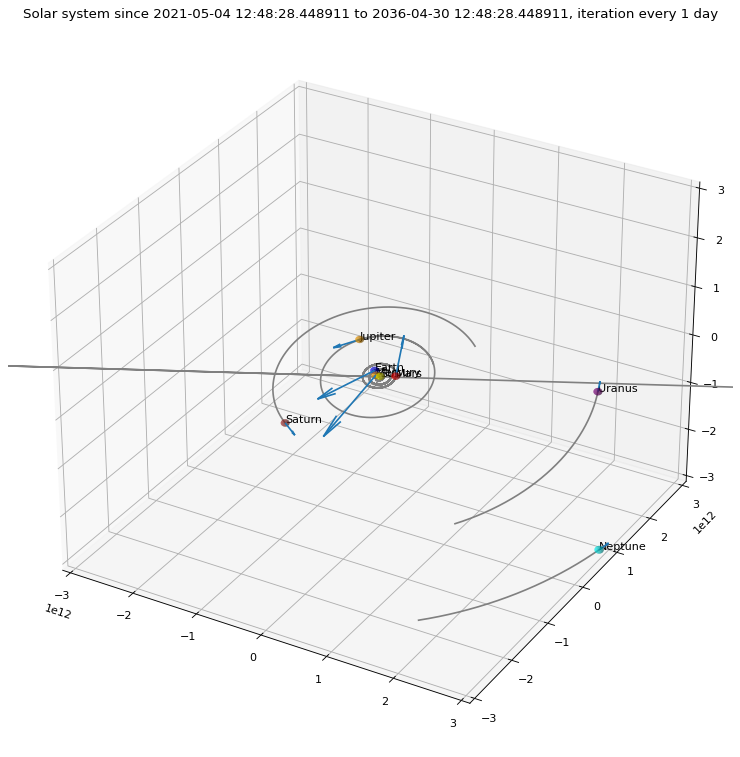

In [169]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt


maxDim=3.0E12


def plotCelestialBodies(bodies,title,includeSpeedVectors = True):
    fig = plt.figure()
    plt.figure(figsize=(12, 12), dpi=80)
    ax = plt.axes(projection='3d')
    plt.title(title)
    plt.xlim([-maxDim, maxDim])
    plt.ylim([-maxDim, maxDim])
    ax.set_zlim(-maxDim,maxDim)
    
    for name,body in bodies.items():
        #somethings bugged for spherical plot and for large R it draws ugly line instead of spehere 
        #scatter is even worse because of calculation of marker size
        r = max(body.radius,maxDim/50)
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x=np.cos(u)*np.sin(v)
        y=np.sin(u)*np.sin(v)
        z=np.cos(v)
        # shift and scale sphere
        x = r*x + body.position[0]
        y = r*y + body.position[1]
        z = r*z + body.position[2]
        ax.plot_surface(x, y, z, color=body.color, alpha=0.5)
        
        if includeSpeedVectors:
            ax.quiver(body.position[0],body.position[1],body.position[2],body.velocity[0]*maxDim/100000,body.velocity[1]*maxDim/100000,body.velocity[2]*maxDim/100000)
        
        #plot path over time
        ax.plot(body.positionHistory[:,0],body.positionHistory[:,1],body.positionHistory[:,2],color="gray")
        ax.text(body.position[0], body.position[1], body.position[2], body.name)
        

        
plotCelestialBodies(celestialBodies,"Solar system since {} to {}, iteration every {} day".format(start,end,1))
